# Chapter 18. Reinforcement Learning

In [33]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import tensorflow.keras as keras
from tf_agents.environments import suite_gym
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks.q_network import QNetwork
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.utils.common import function
from tf_agents.policies.policy_saver import PolicySaver
import logging
from pathlib import Path
import gym
import imageio
import base64
from IPython.display import HTML


%matplotlib inline
np.random.seed(0)
sns.set_style('whitegrid')

## The TF-Agents library

The TF-Agents library is a Reinforcement Learning library based on TF.
It provides many environments, including wrapping around OpenAI Gym, physics engines, and models.
We will use it to train a DQN to play the Atari game *Breakout*.

### TG-Agents environment

We can create Breakout environment which is a wrapper around an OpenAI Gym environment.

In [2]:
breakout_env = suite_gym.load('Breakout-v4')
breakout_env

There are some differences between the APIs of OpenAI Gym and TF-Agents.
For instance, calling the `reset()` method of an environment does not return just the observations, but a `TimeStep` object with a bunch of information.

In [3]:
breakout_env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [4]:
breakout_env.step(1)

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

We can also get the parameters of an environment through specific methods.

In [5]:
breakout_env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [6]:
breakout_env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [7]:
breakout_env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [8]:
breakout_env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

### Environment wrappers and Atari preprocessing

TF-Agents includes *environment wrappers*: wrappers for environments that are automatically involved in very step of the environment and add some extra functionality.
Here are some that seem quite useful:

* `ActionClipWrapper`: Clips the actions to the action specification.
* `ActionDiscretizeWrapper`: If an environment has actions on a continuous scale, this can turn them into a specified number of discrete steps.
* `ActionRepeat`: Repeats each action for multiple steps, accumulating the rewards - this can be useful to speed up the training in some environments.
* `RunStats`: Records environment statistics.
* `TimeLimit`: Interrupts the environment if it runs for longer than a maximum number of steps.
* `VideoWrapper`: Records a video of the environment.

The wrappers for Atari environments are fairly standardized - greyscale and downsampling the observations, max pooling of the last two frames of the game using a 1x1 filter, frame skipping (the default is to skip every 4 frames), end-of-life loss (whether or not to end the game after the player loses a life).

We will not use the frame skipping in this case, but will apply a wrapper that merges 4 frames into one (it helps the agent learn about the direction the ball is moving in).

In [9]:
max_episode_steps = 27000
environment_name = 'BreakoutNoFrameskip-v4'

breakout_env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

Lastly, we can wrap this environment in `TFPyEnvironment` so it is usable from within a TF graph.

In [10]:
tf_env = TFPyEnvironment(breakout_env)

### Training architecture

The TF-Agents training program is usually split into two components, *Collection* and *Training*, and are run in parallel.
These two pieces are shown in the diagram below.

![](assets/rl_atari-breakout/tf-agents_training_architecture.jpg)

On the left, the driver explores the environments using a collect policy to choose actions.
The driver collections *trajectories* (i.e. experiences) and sends them to an observer to be saved to the replay buffer.
On the right, an agent selects batches of trajectories from the replay buffer and trains some networks which the collect policy can use, too.
Overall, the pieces on the left explore the environment and collect trajectories, while the pieces on the right learn and update the collect policy.

Now we can create the components one at a time.

### Creating the Deep Q-Network

The TF-Agents library offers many networks in the `tf_agents.networks` module and submodules.

In [11]:
preprocessing_layer = keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.0
)

conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

We used the `tf_agents.networks.q_network.QNetwork`.
The first two arguments are the `input_tensor_spec` and `action_spec` for the environment.
This is followed by a preprocessing layer that casts the data to 32-bit floats and normalizes the data to fall between 0 and 1.
There are 3 convolutional layers: 32 8x8 filters with stride 4, 64 4x4 filters with a stride of 2, and 64  3x3 filters with a stride of 1.
The last layer is a dense layer with 512 units.
The output is automatically a dense network with the number of units as there are actions (4 in this case).
All layers except for the output layer use a ReLU action funtion, though this can be adjusted using the `activation_fc` argument.
The outputs do not have an activation function and represent the Q-Values for each action given the input state.

### Creating the DQN agent

The TF-Agents library has many types of agents implemented in the `tf_agents.agents` module and its submodules.
We will the use `tf_agents.agents.dqn.dqn_agent.DqnAgent` class and notes on the following code are below.

In [12]:
train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(learning_rate=1.5e-4,
                                     rho=0.95,
                                     momentum=0.0,
                                     epsilon=0.00001,
                                     centered=True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01
)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction='none'),
    gamma=0.99,
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)

agent.initialize()

1. The `train_step` variable will track the training step number and the model will be trained every `update_period` steps.
2. The optimizer is created and the hyperparameters were taken from one of the original DQN papers from 2015.
3. The `epsilon_fn` variable is a `PolynomialDecay` object that will compute the $\epsilon$ value for the $\epsilon$-greedy collect policy, given the current training step. It will scale down from 1.0 to 0.01 over 1 million ALE frames, or 250,000 steps (since we skip with a period of 4). Further, we will training the agent every 4 steps (16 ALE frames), so $\epsilon$ will actually decay over 62,500 training steps.
4. The `DQNAgent` is then built, passing it the time step and action specifications for the environment. It is also given the `QNetwork` we built previously, the optimizer, the number of training steps between target model updates, the loss function to use, the discount factor $\gamma$, the `train_step` variable, and a function with no arguments that returns the $\epsilon$. For the loss function, `reduction = none` prevents the function from taking the mean loss over all instances, and instead returns an error for each instance.
5. The agent is initialized at the end.

### Creating the replay buffer and corresponding observer

The TF-Agents library provides replay buffers implemented in pure Python (submodules beginning with `py_`) or in TF (submodules beginning with `tf_`).
We will use the `TFUniformReplayBuffer` because it provides a high-performance implementation of a replay buffer with uniform sampling.
Some discussion of the parameters are discussed below the code.

In [13]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000
)
# 1000000

* `data_spec`: A `Trajectory` with a description of the various data types reported by the agent.
* `batch_size`: The number of trajectories that will be added at each step. For our purposes this will be 1, but a *batched environment* can group a series of steps into one batch.
* `max_length`: The maximum size of the buffer. This number was taken from the 2015 DQN paper again and is quite large.

Now we can create the observer that will write the trajectories to the replay buffer.
An observer is just a function (or callable object) that takes a trajectory argument.
Thus, we will use the `add_batch()` method from the replay buffer to be the observer.

In [14]:
replay_buffer_observer = replay_buffer.add_batch

### Creating training metrics

The TF-Agents library provides several RL metrics in the `tf_agents.metrics` module, again, some implemented in pure Python and others using TF.
We will use a few to count the number of episodes, number of steps taken, the average return per episode, and average episode length.

In [15]:
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

We can the values of each of these metrics using their `result()` methods.
Alternatively, we can log all of the metrics by calling `log_metrics(train_metrics)`.

In [16]:
logging.basicConfig(level=logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


### Creating the collect driver

The driver is the object the explores an environment using a policy, collects experiences, and broadcasts them to some observers.
At each step, the following can happen:

1. The driver passes the current time step to the collect policy, which uses the time step to choose an action and return and *action step* object containing the action to take.
2. The driver passes the action to the environment which returns the next time step.
3. The drivers creates a trajectory object to represent the this transition and broadcasts it to all the observers.

There are two main driver classes available through TF-Agents: `DynamicStepDriver` and `DynamicEpisodeDriver`.
The former collections experiences for a given number of steps and the latter collects experiences for a given number of episodes.
We will use the `DynamicStepDriver` to collect experiences for 4 steps for each training iteration (as was done in the 2015 paper).

In [17]:
collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

We could not train it by calling its `run()` method, but its best to "warm-up" the replay buffer using a random policy, first.
For this, we will use the `RandomTFPolicy` and create a second driver to run 20,000 steps.

In [18]:
initial_collect_policy = RandomTFPolicy(
    tf_env.time_step_spec(),
    tf_env.action_spec()
)

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=20000
)

final_time_step, final_policy_state = init_driver.run()

In [19]:
final_time_step

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 84, 84, 4), dtype=uint8, numpy=
array([[[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        ...,

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
      

In [20]:
final_policy_state

()

### Creating the dataset

To sample a batch of trajectories from the replay buffer, call its `get_next()` method.
This returns the batch of trajectories and a `BufferInfo` object that contains the sample identifiers and their sampling probabilities.
For example, the following code samples a small batch of two trajectories ("subepisodes") each containing three consecutive steps.

The `trajectories` object is a named tuple with 7 fields.

In [21]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2,
                                                   num_steps=3)
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

There are 2 trajaectories each of size 3.
Each trajectory is of size 84x84x4.

In [22]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [23]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [24]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

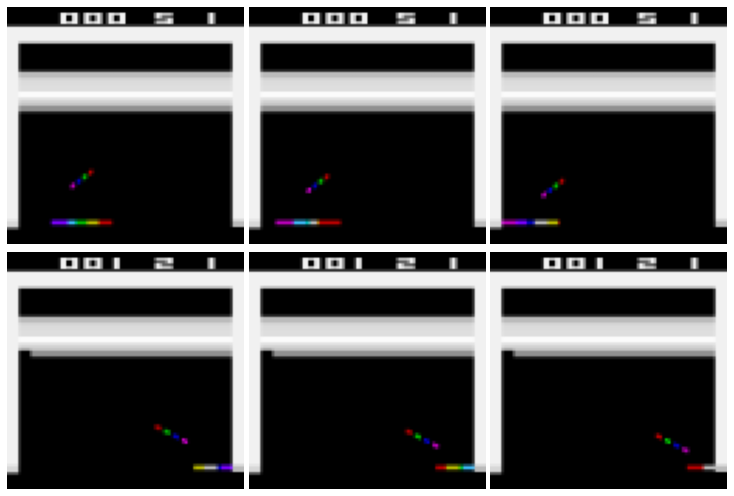

In [25]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
plt.show()

For the main training loop, we will use a `tf.data.Dataset` so we can benefit from the power of the Data API.
This can be accessed via the replay buffer's `as_dataset()` function.

In [26]:
dataset = replay_buffer.as_dataset(sample_batch_size=64,
                                   num_steps=2,
                                   num_parallel_calls=3).prefetch(3)

### Creating the training loop

Converting the main functions to F functions will speed up training.

In [27]:
collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

Now we can create a small function to train the agent over `n_iterations`.

In [48]:
def train_agent(agent, n_iterations, env, collect_driver):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(env.batch_size)
    
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print(f"\r{iteration} loss: {train_loss.loss.numpy():.5f}", end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [49]:
train_agent(agent, 1000, tf_env, collect_driver)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 56
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


999 loss: 0.00005

### Recording the game

I followed the example in this TF [tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) to record a game.

In [50]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)

In [65]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = tf_env.reset()
            video.append_data(breakout_env.render())
            while not time_step.is_last():
                print(time_step.reward.numpy())
                action_step = policy.action(time_step)
                time_step = tf_env.step(action_step.action)
                video.append_data(breakout_env.render())
    return embed_mp4(filename)

In [68]:
create_policy_eval_video(agent.policy, "assets/rl_atari-breakout/trained-agent", num_episodes=5, fps=30)

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
